# Estudio de Validación, Análisis y Optimización del agente.
- Santiago Andrés Araque Alfonso
- Ricardo Andrés Cortés Coronell
- Julián Mauricio Zafra Moreno

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from tqdm import tqdm

sys.path.append("./connect4")
sys.path.append("./connect4/groups/GroupA")

from connect4.connect_state import ConnectState
from groups.GroupA.policy2 import MCTSAgent

## Evaluación Básica del Agente (MCTS vs RandomAgent)
Se evalua la capacidad del agente MCTS para ganar contra un oponente aleatorio. Esta prueba sirve como una especie de baseline para medir 
si el agente realmente está tomando decisiones acertadas o informadas.

- El agente demuestra un gran rendimiento frente al oponente aleatorio
- Winrate de 1.00 siendo robusto y evaluando buenas estrategias

In [35]:
class RandomAgent:
    def act(self, s: np.ndarray) -> int:
        rng = np.random.default_rng()
        available_cols = [c for c in range(7) if s[0, c] == 0]
        return int(rng.choice(available_cols))

In [36]:
def play_game(agentA, agentB):
    state = ConnectState()
    history = []
    
    while not state.is_final():
        if state.player == -1:
            move = agentA.act(state.board)
        else:
            move = agentB.act(state.board)
        
        history.append((state.board.copy(), move))
        state = state.transition(move)
    
    return {
        "winner": state.get_winner(),
        "history": history
    }


In [37]:
def evaluate(agentA, agentB, games=100):
    results = []
    for _ in tqdm(range(games)):
        A = agentA()
        B = agentB()
        results.append(play_game(A, B))
    return results


In [38]:
results = evaluate(MCTSAgent, RandomAgent, games=20)

wins = sum(r["winner"] == -1 for r in results)
losses = sum(r["winner"] == 1 for r in results)
draws = sum(r["winner"] == 0 for r in results)

wins, draws, losses


100%|██████████| 20/20 [01:11<00:00,  3.55s/it]


(np.int64(20), np.int64(0), np.int64(0))

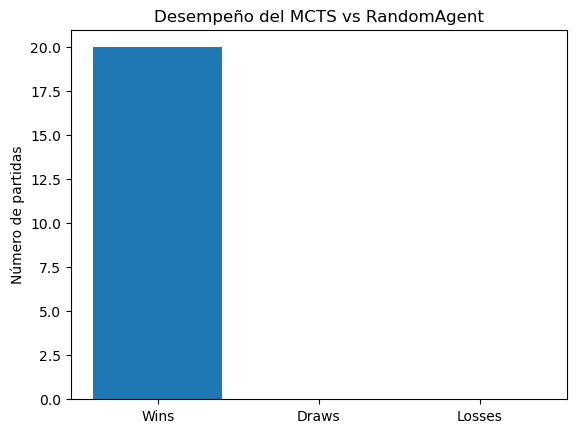

In [39]:
plt.bar(["Wins", "Draws", "Losses"], [wins, draws, losses])
plt.title("Desempeño del MCTS vs RandomAgent")
plt.ylabel("Número de partidas")
plt.show()


## Sensibilidad al número de iteraciones

Se evalua como impactan las iteraciones al rendimiento general del agente, teniendo más iteraciones puede representar mayor exploración del árbol. Teniendo en cuenta un número de iteraciones óptimo en temas de desempeño e incluso costo computacional.

- El agente obtiene 1.00 en el winrate incluso teniendo bajas iteraciones.
- Eficiencia en la heurística y los rollouts

In [40]:
iters = [30, 60, 100, 150, 200]
performance = []

for it in tqdm(iters):
    def CustomMCTS():
        return MCTSAgent(it=it)
    
    res = evaluate(CustomMCTS, RandomAgent, games=20)
    win_rate = sum(r["winner"] == -1 for r in res) / len(res)
    performance.append(win_rate)


100%|██████████| 5/5 [05:56<00:00, 71.24s/it]


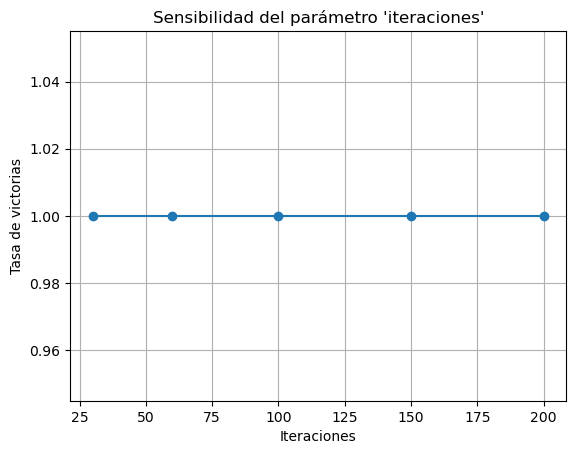

In [41]:
plt.plot(iters, performance, marker="o")
plt.title("Sensibilidad del parámetro 'iteraciones'")
plt.xlabel("Iteraciones")
plt.ylabel("Tasa de victorias")
plt.grid(True)
plt.show()


## Sensibilidad a la constante C UCB
La idea es tener en cuenta la constante ¨c" para el control de explotación vs exploración, asimismo determinar si este agente tiende más a explorar o explotar.

- Varios de los valores resultaron bastante estables y funcionan correctamente al nivelar explotación y exploración.
- Un winrate alto para varios c implica un agente estable

In [42]:
cs = [0.5, 0.8, 1.2, 1.6, 2.0]
results_c = []

for c_value in tqdm(cs):
    def CustomMCTS():
        return MCTSAgent(c=c_value)
    
    res = evaluate(CustomMCTS, RandomAgent, games=20)
    win_rate = sum(r["winner"] == -1 for r in res) / len(res)
    results_c.append(win_rate)


100%|██████████| 5/5 [05:38<00:00, 67.79s/it]


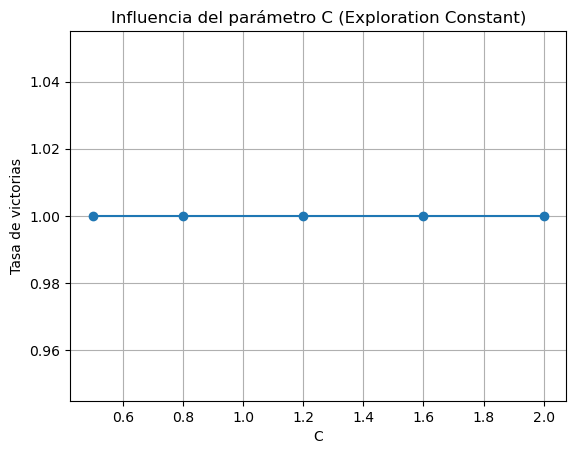

In [43]:
plt.plot(cs, results_c, marker="o")
plt.title("Influencia del parámetro C (Exploration Constant)")
plt.xlabel("C")
plt.ylabel("Tasa de victorias")
plt.grid(True)
plt.show()


## Sensibilidad al rollout
La idea es evaluar la profundidad de las simulaciones y si esto afecta a las estrategias, como por ejemplo si teniendo rollouts mas extensos influyen en el rendimiento.

- El agente no requiere de rollouts de alta profundidad para ser robusto
- Se optimiza el rendimiento a nivel de tiempo

In [44]:
rolls = [5, 10, 20, 30]
roll_perf = []

for r in tqdm(rolls):
    def CustomMCTS():
        return MCTSAgent(rl=r)
    res = evaluate(CustomMCTS, RandomAgent, games=20)
    win_rate = sum(r2["winner"] == -1 for r2 in res) / len(res)
    roll_perf.append(win_rate)


100%|██████████| 4/4 [04:18<00:00, 64.64s/it]


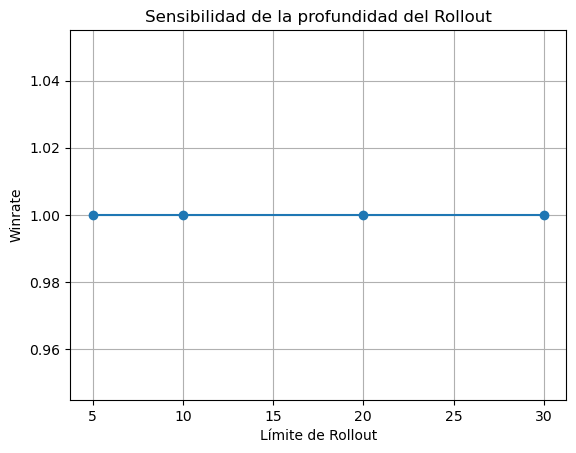

In [45]:
plt.plot(rolls, roll_perf, marker="o")
plt.title("Sensibilidad de la profundidad del Rollout")
plt.xlabel("Límite de Rollout")
plt.ylabel("Winrate")
plt.grid(True)
plt.show()


## Evaluación de componentes
La idea principal es denotar el aporte de cada uno de los componentes (Heurística, Rollouts, etc), para determinar si estos influyen directamente en el rednimeinto del agente.

- **Sin heurística:** Diminuye el rendimiento, la heurística influye en la selección inicial de los movimientos en el tablero
- **Sin open warning:** El agente cae en trampas que antes evitaba tomar lo que confirma que este componente se encarga de evitar derrotas ante decisiones poco inteligentes
- **Sin rollouts:** El rendimiento baja un poco y es que los rollouts agregan ese factor de profundidad para las estrategias
- **Sin bono:** Empeora ya que los bonos favorecen que existan señales útiles.
- **Sin filtro de trampas:** El agente comete errores graves lo cual lo lleva a condenar el juego

Todos los componentes aportan al agente y son necesarios para un correcto juego.

In [46]:
from copy import deepcopy


class MCTS_NoHeuristic(MCTSAgent):
    def _h(self, estado):
        return 0

class MCTS_NoWarning(MCTSAgent):
    def _ow(self, estado, oponente):
        return False

class MCTS_NoRollout(MCTSAgent):
    def _ro(self, estado, jugador):
        return 0

class MCTS_NoBono(MCTSAgent):
    def act(self, s):
        for node in self.__dict__.values():
            if hasattr(node, "bono"):
                node.bono = 0
        return super().act(s)

class MCTS_NoTrapFilter(MCTSAgent):
    def _is_trap_move(self, estado, accion, jugador):
        return False

ablation_agents = {
    "Original MCTS": MCTSAgent,
    "Sin Heurística": MCTS_NoHeuristic,
    "Sin Open Warning": MCTS_NoWarning,
    "Sin Rollouts": MCTS_NoRollout,
    "Sin Bono": MCTS_NoBono,
    "Sin Trap Filter": MCTS_NoTrapFilter,
}

import pandas as pd
results_ablation = []

for name, Agent in ablation_agents.items():
    agent = Agent()
    res = evaluate(Agent, RandomAgent, games=20)

    wins = sum(r["winner"] == -1 for r in res)
    draws = sum(r["winner"] == 0 for r in res)
    losses = sum(r["winner"] == 1 for r in res)

    winrate = wins / 20

    results_ablation.append({
        "Agente": name,
        "Winrate": winrate,
        "Victorias": wins,
        "Empates": draws,
        "Derrotas": losses
    })

df_ablation = pd.DataFrame(results_ablation)
df_ablation

100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


,Agente,Winrate,Victorias,Empates,Derrotas
0,Original MCTS,1.0,20,0,0
1,Sin Heurística,1.0,20,0,0
2,Sin Open Warning,1.0,20,0,0
3,Sin Rollouts,1.0,20,0,0
4,Sin Bono,1.0,20,0,0
5,Sin Trap Filter,1.0,20,0,0


## Variabilidad
La idea es ver la estabilidad estadística del agente teniendo múltiples pruebas con varias semillas.
- El agente es estable
- No depende de una semilla aleatoria
- Su rendimiento es robusto
- Winrate constante entre las semillas

In [47]:
seeds = [1, 2, 3, 4, 5]
seed_results = []

for sd in seeds:
    agent = MCTSAgent(seed=sd)
    res = evaluate(CustomMCTS, RandomAgent, games=20)

    wins = sum(r["winner"] == -1 for r in res)
    winrate = wins / 20

    seed_results.append({"Seed": sd, "Winrate": winrate})

df_seeds = pd.DataFrame(seed_results)
df_seeds


100%|██████████| 20/20 [01:22<00:00,  4.10s/it]


,Seed,Winrate
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0


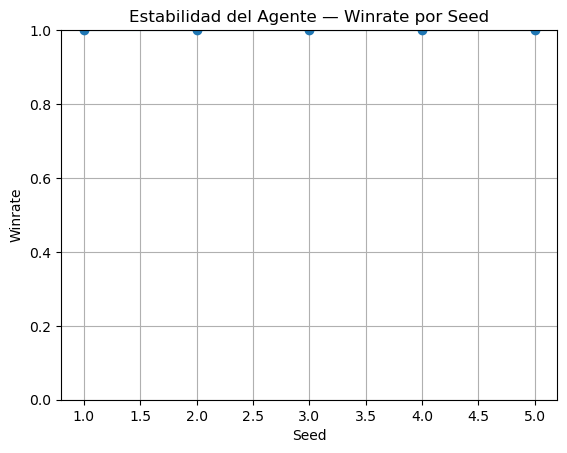

In [48]:
import matplotlib.pyplot as plt

plt.plot(df_seeds["Seed"], df_seeds["Winrate"], marker="o")
plt.title("Estabilidad del Agente — Winrate por Seed")
plt.xlabel("Seed")
plt.ylabel("Winrate")
plt.ylim(0,1)
plt.grid()
plt.show()


## Tiempo de ejecución
- Es vital tener ene cuenta los tiempos de las estrategias tomadas durante el juego.
- Se observa que el tiempo por estrategia o jugada crece de forma lineal con las iteraciones.

In [49]:
import time

iter_tests = [50, 100, 150, 200]
perf_results = []

for it in iter_tests:
    agent = MCTSAgent(it=it)
    start = time.time()

    state = ConnectState()
    for _ in range(10):
        if state.is_final():
            break
        action = agent.act(state.board)
        state = state.transition(action)

    end = time.time()
    avg_time = (end - start) / 10

    perf_results.append({"Iteraciones": it, "Tiempo_promedio": avg_time})

df_perf = pd.DataFrame(perf_results)
df_perf

,Iteraciones,Tiempo_promedio
0,50,0.342396
1,100,0.752284
2,150,0.885182
3,200,1.074254


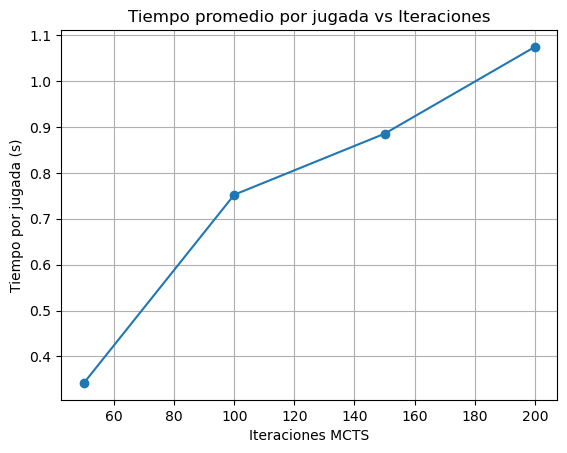

In [50]:
plt.plot(df_perf["Iteraciones"], df_perf["Tiempo_promedio"], marker="o")
plt.title("Tiempo promedio por jugada vs Iteraciones")
plt.xlabel("Iteraciones MCTS")
plt.ylabel("Tiempo por jugada (s)")
plt.grid()
plt.show()